# Gaussian mixture model

The model in prototyped with TensorFlow Probability and inferecne is performed with variational Bayes by stochastic gradient descent. 
Details on [Wikipedia](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model).

Some codes are borrowed from 
[Brendan Hasz](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html) and 
[TensorFlow Probability examples](https://www.tensorflow.org/probability/overview)

Author: Yuanhua Huang

Date: 29/01/2020

#### Definition of likelihood

Below is the definition of likelihood by introducing the latent variable Z for sample assignment identity, namely, Z is a Categorical distribution (a sepcial case of multinomial with total_counts=1), and the prior $P(z_i=k)$ can be specified per data point or shared by whole data set:

$$ \mathcal{L} = P(X | \mu, \sigma, Z) = \prod_{i=1}^N \prod_{j=1}^D \prod_{k=1}^K P(z_i=k) \{ \mathcal{N}(x_{ij}|\mu_{k,j}, \sigma_{k,j}) \}^{z_i=k}$$

The evidence lower bound (ELBO) can be written as 

$$\mathtt{L}=\mathtt{KL}(q(Y)||p(Y)) - \int{q(Y)\log{p(X|Y)}dY}$$

where $Y$ denotes the set of all unknown variables and $X$ denotes the observed data points. The derivations can be found in page 463 in [Bishop, PRML 2006](https://www.springer.com/gp/book/9780387310732).

**Note**, this implementation is mainly for tutorial example, and hasn't been optimised, for example introducing multiple initialization to avoid local optimal caused by poor initialization.

**Also**, the assignment variable $z$ can be marginalised and the impelementation can be found in 
[GaussianMixture_VB.ipynb](https://github.com/huangyh09/TensorFlow-Bayes/blob/master/examples/GaussianMixture_VB.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Random seed
np.random.seed(1)
tf.random.set_seed(1)

## Generate data

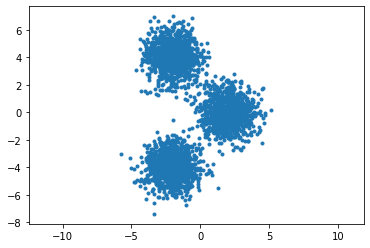

In [2]:
# Generate some data
np.random.seed(0)
N = 3000
X = np.random.randn(N, 2).astype('float32')
X[:1000, :] += [2, 0]
X[1000:2000, :] -= [2, 4]
X[2000:, :] += [-2, 4]

# Plot the data
plt.plot(X[:, 0], X[:, 1], '.')
plt.axis('equal')
plt.show()

## Define model

In [3]:
from TFBayes.mixture.Gaussian_MM_full import GaussianMixture

In [4]:
model = GaussianMixture(3, 2, 3000)
# model.set_prior(theta_prior = tfd.Dirichlet(5 * tf.ones((3, ))))
model.KLsum

<tf.Tensor: id=159, shape=(), dtype=float32, numpy=861.6132>

In [5]:
# model.alpha, model.beta, model.gamma

In [6]:
# losses = model.fit(X, sampling=False, learn_rate=0.03, num_steps=500)
losses = model.fit(X, sampling=True, learn_rate=0.02, num_steps=500, n_sample=10)

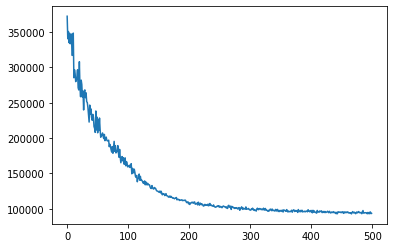

In [7]:
plt.plot(losses)
plt.show()

Text(0, 0.5, 'Likelihood')

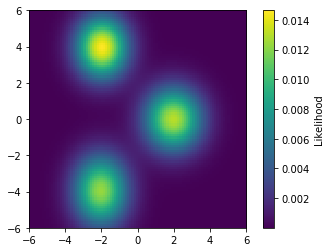

In [8]:
# Compute log likelihood at each point on a grid
Np = 100 #number of grid points
Xp, Yp = np.meshgrid(np.linspace(-6,6,Np), np.linspace(-6,6,Np))
Pp = np.column_stack([Xp.flatten(), Yp.flatten()])
Z = model.logLik(Pp.astype('float32'), sampling=False, use_ident=False)
Z = np.reshape(Z, (Np, Np))
        
# Show the fit mixture density
plt.imshow(np.exp(Z),
           extent=(-6, 6, -6, 6),
           origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')

## Model
The codes below is also included in [TFBayes.mixture.Gaussian_MM_full.py](https://github.com/huangyh09/TensorFlow-Bayes/blob/master/TFBayes/mixture/Gaussian_MM_full.py).

In [9]:
class GaussianMixture():
    """A Bayesian Gaussian mixture model.
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    Nc : int > 0
        Number of mixture components.
    Nd : int > 0
        Number of dimensions.
    Ns : int > 0
        Number of data points.
    """
    def __init__(self, Nc, Nd, Ns=0):
        # Initialize
        self.Nc = Nc
        self.Nd = Nd
        self.Ns = Ns
        
        # Variational distribution variables for means
        self.locs = tf.Variable(tf.random.normal((Nc, Nd)))
        self.scales = tf.Variable(tf.pow(tf.random.gamma((Nc, Nd), 5, 5), -0.5))
        
        # Variational distribution variables for standard deviations
        self.alpha = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        self.beta = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        
        # Variational distribution variables for assignment logit
        self.gamma = tf.Variable(tf.random.uniform((Ns, Nc), -2, 2))
        
        self.set_prior()
        
    def set_prior(self, mu_prior=None, sigma_prior=None, ident_prior=None):
        """Set prior ditributions
        """
        # Prior distributions for the means
        if mu_prior is None:
            self.mu_prior = tfd.Normal(tf.zeros((self.Nc, self.Nd)), 
                                       tf.ones((self.Nc, self.Nd)))
        else:
            self.mu_prior = self.mu_prior

        # Prior distributions for the standard deviations
        if sigma_prior is None:
            self.sigma_prior = tfd.Gamma(2 * tf.ones((self.Nc, self.Nd)), 
                                         2 * tf.ones((self.Nc, self.Nd)))
        else:
            self.sigma_prior = sigma_prior
        
        # Prior distributions for sample assignment
        if ident_prior is None:
            self.ident_prior = tfd.Multinomial(total_count=1,
                            probs=tf.ones((self.Ns, self.Nc))/self.Nc)
        else:
            self.ident_prior = ident_prior
    
    @property
    def mu(self):
        """Variational posterior for distribution mean"""
        return tfd.Normal(self.locs, self.scales)
    
    @property
    def sigma(self):
        """Variational posterior for distribution variance"""
        return tfd.Gamma(self.alpha, self.beta)
        # return tfd.Gamma(tf.math.exp(self.alpha), tf.math.exp(self.beta))
    
    @property
    def ident(self):
        return tfd.Multinomial(total_count=1, 
                               probs=tf.math.softmax(self.gamma))

    
    @property
    def KLsum(self):
        """
        Sum of KL divergences between posteriors and priors
        The KL divergence for multinomial distribution is defined manually
        """
        kl_mu    = tf.reduce_sum(tfd.kl_divergence(self.mu,    self.mu_prior))
        kl_sigma = tf.reduce_sum(tfd.kl_divergence(self.sigma, self.sigma_prior))
        kl_ident = tf.reduce_sum(self.ident.mean() * 
                                 tf.math.log(self.ident.mean() / 
                                             self.ident_prior.mean())) # axis=0
        
        return kl_mu + kl_sigma + kl_ident
    
        
    def logLik(self, x, sampling=False, n_sample=10, use_ident=True):
        """Compute log likelihood given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor, (n_sample, n_dimention)
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
        n_sample : int
            The number of samples to generate
        use_ident : bool
            Setting True for fitting the model and False for testing logLik
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        """
        #TODO: sampling doesn't converge well in the example data set

        Nb, Nd = x.shape
        x = tf.reshape(x, (1, Nb, 1, Nd)) # (n_sample, Ns, Nc, Nd)

        # Sample from the variational distributions
        if sampling:
            _mu = self.mu.sample((n_sample, 1))
            _sigma = tf.pow(self.sigma.sample((n_sample, 1)), -0.5)
        else:
            _mu = tf.reshape(self.mu.mean(), (1, 1, self.Nc, self.Nd))
            _sigma = tf.pow(tf.reshape(self.sigma.mean(), 
                                       (1, 1, self.Nc, self.Nd)), -0.5)
        
        # Calculate the probability density
        _model = tfd.Normal(_mu, _sigma)
        _log_lik_mix = _model.log_prob(x)
        
        if use_ident:
            _ident = tf.reshape(self.ident.mean(), (1, self.Ns, self.Nc, 1))
            _log_lik_mix = _log_lik_mix * _ident
            log_likelihoods = tf.reduce_sum(_log_lik_mix, axis=[0, 2, 3])
        else:
            _fract = tf.reshape(tf.reduce_mean(self.ident.mean(), axis=0),
                                (1, 1, self.Nc, 1))
            _log_lik_mix = _log_lik_mix + tf.math.log(_fract)
            log_likelihoods = tf.reduce_mean(tf.math.reduce_logsumexp(
                tf.reduce_sum(_log_lik_mix, axis=3), axis=2), axis=0)
        
        return log_likelihoods
    
    def fit(self, x, num_steps=200, 
            optimizer=None, learn_rate=0.05, **kwargs):
        """Fit the model's parameters"""
        if optimizer is None:
            optimizer = tf.optimizers.Adam(learning_rate=learn_rate)
            
        loss_fn = lambda: (self.KLsum - 
            tf.reduce_sum(self.logLik(x, **kwargs)))
        
        losses = tfp.math.minimize(loss_fn, 
                                   num_steps=num_steps, 
                                   optimizer=optimizer)
        return losses